# Decision Tree & Random Forest

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer
import matplotlib.pyplot as plt

## Decision Tree
Decision Tree(의사결정나무)는 데이터의 독립변수에 대한 규칙을 순차적으로 적용하면서 분류하는 모델이다. 마치 스무고개와 같은 원칙을 가지는 모델이다.

그림으로 더 자세히 이해할 수 있으며 여러 [블로그](https://ratsgo.github.io/machine%20learning/2017/03/26/tree/)를 통해 원리에 대해 간략하게 이해를 할 수 있다.

다음은 Decision tree의 구현이다. 구현을 이해하기 위해 필요한 여러 개념에 대해 알아보자.

In [2]:
class DT:
    def __init__(self, max_depth=2, weights=None):
        self.max_depth = max_depth
        self.weights = weights
        
    def fit(self, X, y):
        self.target_size = np.max(y) + 1
        self.tree = self._make_tree(X, y, self.max_depth, self.weights)
    
    def _gini(self, y, weights):
        unique, cnt = np.unique(y, return_counts=True)
        if weights is not None:
            cnt = np.array([np.sum(weights[np.where(y==i)[0]]) for i in unique])
        cnt = cnt / cnt.sum()
        return 1 - np.sum(cnt * cnt)
    
    def _make_tree(self, X, y, depth, weights):
        # leaf node
        if depth == 0 or len(np.unique(y)) == 1:
            prob = np.zeros(self.target_size)
            unique, cnt = np.unique(y, return_counts=True)
            if self.weights is not None:
                cnt = np.array([weights[np.where(y==i)[0]].sum() for i in unique])
            prob[unique] = cnt / cnt.sum()
            return { "leaf": True, "prob": prob, "size": len(y) }   # 가능한 모든 규칙을 다 찾는 것

        min_gini = 1
        min_col = 0
        split = None

        for i, col in enumerate(X.T):   # 모든 feature에 대해서 (i: feature index, col: all values of i'th feature)
            u = np.sort(np.unique(col)) # 모든 가능한 split value를 만들기 위한 작업
            u = (u[1:] + u[:-1]) / 2    # 중간값을 split value로 사용

            for val in u:   # 모든 가능한 split value에 대해서
                lt, rt = np.where(col <= val), np.where(col > val)  # split value보다 작은 값과 큰 값으로 나누기
                y_lt, y_rt = y[lt], y[rt]                           # 나뉜 두 트리
                if weights is None:                            # weight가 없는 경우 = 모두 1로 보고 gini 계산
                    cur_gini = (len(y_lt)*self._gini(y_lt, None) + len(y_rt)*self._gini(y_rt, None)) / (len(y))
                else:
                    w_lt, w_rt = weights[lt], weights[rt]       # weight가 있는 경우 = weight를 곱해서 gini 계산
                    cur_gini = (w_lt.sum()*self._gini(y_lt, w_lt) + w_rt.sum()*self._gini(y_rt, w_rt)) / weights.sum()
                    
                if cur_gini < min_gini:     # gini가 가장 작은 split value를 찾기
                    min_gini, min_col, split = cur_gini, i, val

        lt = np.where(X[:, min_col] <= split)[0]
        rt = np.where(X[:, min_col] > split)[0]
        return {
            "split": (min_col, split),
            "lt": self._make_tree(X[lt, :], y[lt], depth-1, weights[lt] if weights is not None else None),
            "rt": self._make_tree(X[rt, :], y[rt], depth-1, weights[rt] if weights is not None else None),
            "leaf": False,
            "size": len(y)
        }
    
    def _predict_one(self, x):
        cur = self.tree
        while cur["leaf"] == False:
            col, split = cur["split"]
            cur = cur["lt"] if x[col] <= split else cur["rt"]
        return cur["prob"]
    
    def predict(self, X):
        return np.apply_along_axis(self._predict_one, 1, X)
    
    
data = load_iris()
features_name = data.feature_names
data, target = data['data'], data['target']

dt = DT(max_depth=3, weights=None)
dt.fit(data, target)


## 불순도/불확실성
Decision tree를 만들 때 적용할 수 있는 규칙은 다양하지만, 최대한 좋은 성능을 내기 위해선 트리의 매 노드마다 특정 클래스가 가지는 공통된 특성을 파악하여 분할 할 필요가 있다.

이러한 문제를 해결하기 위해 도입한 개념이 불순도이다. 예시를 통해 살펴보자.

다음은 유방암 환자에 대한 데이터이다.

In [3]:
bc = load_breast_cancer()
data = pd.DataFrame(bc["data"], columns=bc["feature_names"])
data["target"] = bc["target"]
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


가령 mean radius의 평균값인 14를 기준으로 데이터를 나눈다고 하자. 각 데이터에 대해 target이 1인 비율은 아래와 같다.

mean radius가 평균보다 작을때 target이 1인 경우가 압도적으로 높고, 반면 클 때는 매우 낮다는 것을 확인 할 수 있다. 즉, mean radius의 평균값을 기준으로 하면 데이터의 분류가 잘 된다는 뜻이다.

In [5]:
mr_low = data[data["mean radius"] < 14]["target"]
mr_high = data[data["mean radius"] >= 14]["target"]

print(f'Is mean radius lower than 14?:')
print(f'low: {mr_low.sum() / len(mr_low):.3f}, high: {mr_high.sum() / len(mr_high):.3f}')

Is mean radius lower than 14?:
low: 0.905, high: 0.224


mean smoothness의 평균값을 기준으로 데이터를 나누는 경우엔 mean radius에 비해 분류를 잘하지 못한다는 것을 알 수 있다. 즉, 분류된 데이터가 **불확실**하다는 것을 확인 할 수 있다.

In [6]:
ms_low = data[data["mean smoothness"] < 0.096]["target"]
ms_high = data[data["mean smoothness"] >= 0.096]["target"]

print('Is mean smoothness lower than 0.096?:')
print(f'low: {ms_low.sum() / len(ms_low):.3f}, high: {ms_high.sum() / len(ms_high):.3f}')

Is mean smoothness lower than 0.096?:
low: 0.771, high: 0.480


위 예제를 통해 불확실성이 낮아지면 정보를 얻을 수 있다는 것을 확인했다.

Decision tree에서는 가장 정보를 많이 얻을 수 있는 규칙을 찾기 위해 불확실성을 수치화한 후, 규칙을 적용하기 전후의 불확실성 차를 최대화하는 규칙을 적용한다.

데이터의 불확실성을 나타내는 지표로는 대표적으로 **엔트로피**와 **지니 계수**가 있다.

### 엔트로피
엔트로피는 다음과 같이 정의된다. 이 때. $p_k$는 범주 $k$에 속하는 데이터의 비율이다.
$$ Entropy(A)=H(A)=-\sum_k{p_k log(p_k)} $$
위 수식이 불확실성을 잘 나타내는지 알아보기 위해 예제를 통해 살펴보자. 그래프에서 볼 수 있듯이 A1의 불확실성이 가장 높고 A3의 불확실성이 가장 낮다.

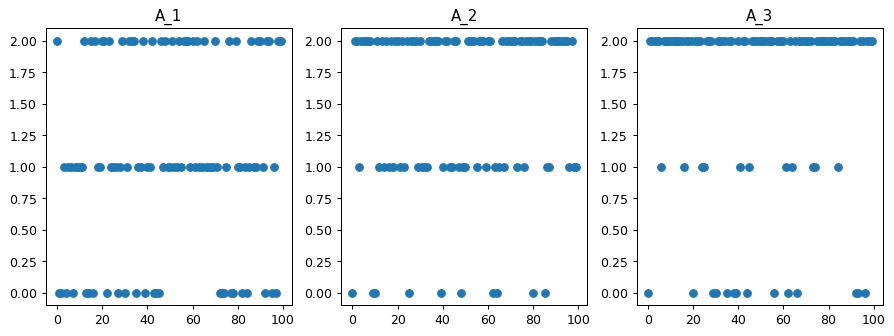

In [7]:
# p는 각 범주가 나타날 확률이므로, A_1이 가장 불확실성이 높고 A_3이 가장 불확실성이 낮다.
A_1 = np.random.choice(3, 100, p=[1/3,1/3,1/3])
A_2 = np.random.choice(3, 100, p=[1/7,2/7,4/7])
A_3 = np.random.choice(3, 100, p=[1/10,1/10,8/10])

plt.figure(figsize=(12,4), dpi=90)
plt.subplot(1,3,1)
plt.scatter(np.arange(100),A_1)
plt.title("A_1")
plt.subplot(1,3,2)
plt.title("A_2")
plt.scatter(np.arange(100),A_2)
plt.subplot(1,3,3)
plt.title("A_3")
plt.scatter(np.arange(100),A_3)
plt.show()

In [8]:
def entropy(A):
    _, count = np.unique(A, return_counts=True)
    p = count / len(A)
    return -np.sum(p*np.log(p))

print(f'A_1 entropy: {entropy(A_1):.3f}')
print(f'A_2 entropy: {entropy(A_2):.3f}')
print(f'A_3 entropy: {entropy(A_3):.3f}')

A_1 entropy: 1.077
A_2 entropy: 0.891
A_3 entropy: 0.734


## 지니 계수
지니 계수 또한 데이터의 불확실성을 나타낼 수 있다. 위 DT 클래스에서는 지니 계수를 사용한다. 지니 계수에 대한 공식은 다음과 같다.
$$ Gini(A)=1-\sum_k{{p_k}^2} $$
같은 예제를 통해 지니 계수도 불확실성을 잘 나타내는지 확인하자.

In [9]:
def gini(A):
    _, count = np.unique(A, return_counts=True)
    p = count / len(A)
    return 1-np.sum(p**2)

print("A_1 gini: {:.3f}".format(gini(A_1)))
print("A_2 gini: {:.3f}".format(gini(A_2)))
print("A_3 gini: {:.3f}".format(gini(A_3)))

A_1 gini: 0.652
A_2 gini: 0.534
A_3 gini: 0.406


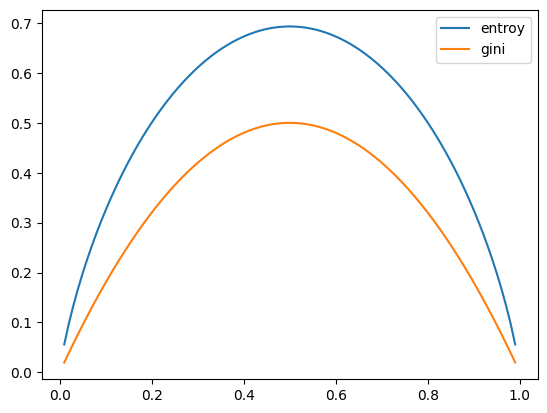

In [10]:
p = np.linspace(0.01, 0.99, 100)
plt.plot(p, -p*np.log(p) - (1-p)*np.log(1-p), label='entroy')
plt.plot(p, 1 - p**2 - (1-p)**2, label='gini')
plt.legend()

## DT 실습

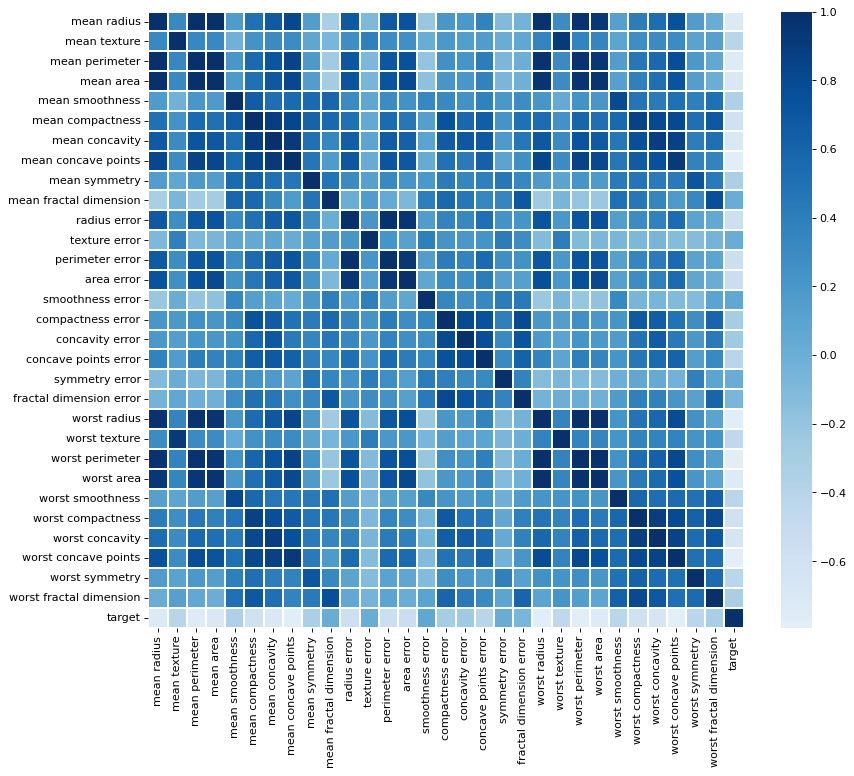

In [11]:
# correlation matrix
import seaborn as sns

plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(data.corr(), annot=False, cmap='Blues', center=0, linewidths=0.2)
plt.show()

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data["data"], data["target"], 
                                                    test_size=0.2, random_state=42, stratify=data["target"])

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2]), array([40, 40, 40]))
(array([0, 1, 2]), array([10, 10, 10]))


### entropy 를 이용한 분류

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
# entropy
decision_tree = DecisionTreeClassifier(criterion='entropy',
                                       splitter='best',
                                       max_depth=None,
                                       random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



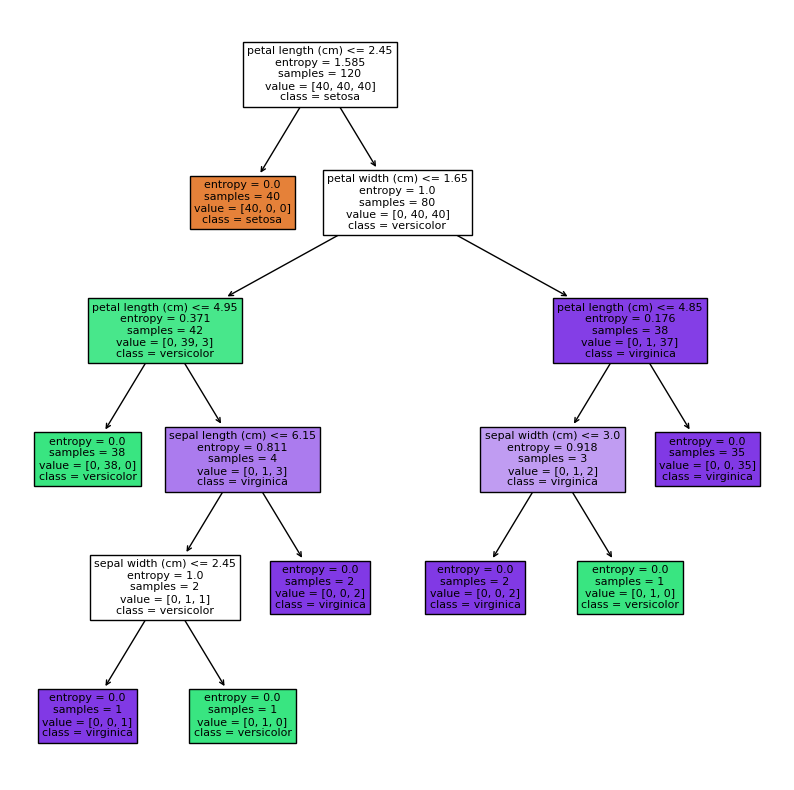

In [14]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 10), dpi=100)
plot_tree(decision_tree, filled=True, feature_names=data["feature_names"], class_names=data["target_names"])
plt.show()

### gini 계수를 이용한 분류

In [15]:
# gini
decision_tree = DecisionTreeClassifier(criterion='gini',
                                       splitter='best',
                                       max_depth=None,
                                       random_state=42)

decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



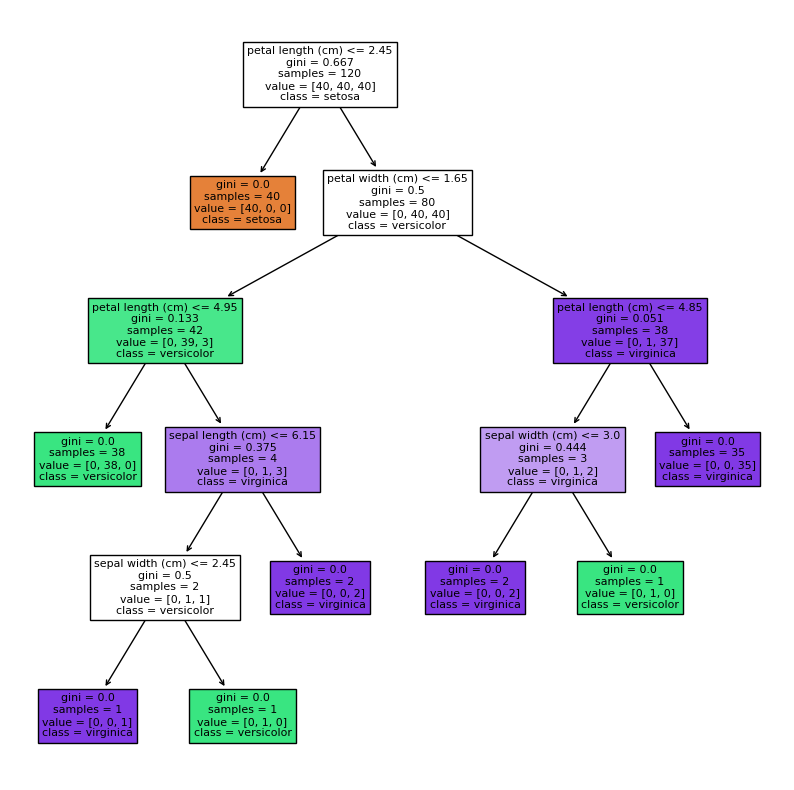

In [16]:
plt.figure(figsize=(10, 10), dpi=100)
plot_tree(decision_tree, filled=True, feature_names=data["feature_names"], class_names=data["target_names"])
plt.show()

### pruning

In [17]:
decision_tree = DecisionTreeClassifier(criterion='entropy',
                                       splitter='best',
                                       max_depth=3,
                                       random_state=42)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



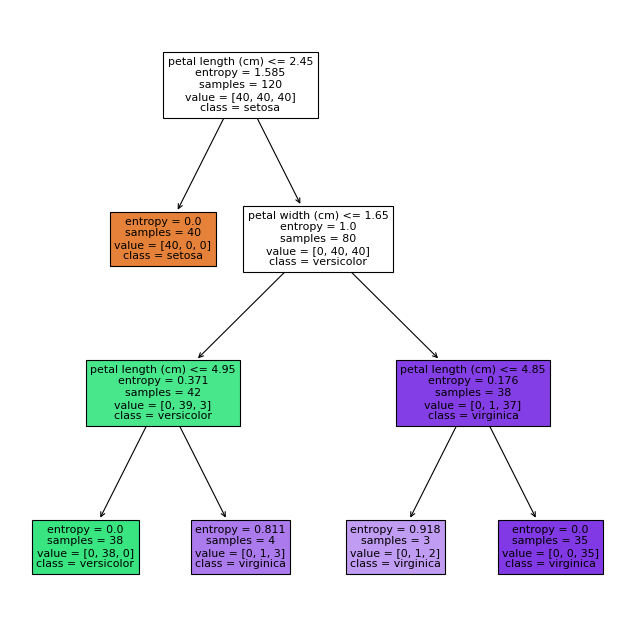

In [18]:
plt.figure(figsize=(10, 10), dpi=80)
plot_tree(decision_tree, filled=True, feature_names=data["feature_names"], class_names=data["target_names"])
plt.show()

## Random Forest
머신러닝에서 여러 모델을 합쳐 더 좋은 성능을 내는 새로운 모델을 만드는 기법을 앙상블이라 한다. Random forest는 여러개의 decision tree를 앙상블한 모델이라고 할 수 있다.

Decision tree는 일반적으로 좋은 성능을 낼 수는 있지만, 쉽게 과적합된다는 단점이 있다. 이를 해결하기 위해 트리의 최대 깊이를 제한하는 방식을 사용하여 과적합 문제는 해결할 수 있지만, 반대로 성능이 낮아지는 결과를 초래하기도 한다.

앞서 설명했듯이 decision tree를 생성하는 방법은 어떤 규칙을 적용하는지, 혹은 최대 깊이를 얼마나 제한하는지 등 다양한 조건에 따라 서로 다른 트리를 만들 수 있다. Random forest에서는 이렇게 여러 조건을 바탕으로 서로 다른 decision tree를 여러개 만들어 각 트리가 낸 결과들을 모아서 최종 결과를 출력하는 모델이다.

구체적인 알고리즘 및 구현은 다음 [블로그](https://eunsukimme.github.io/ml/2019/11/26/Random-Forest/)를 통해 알 수 있다.

Decision tree나 random forest 모델의 경우 분석가가 직접 정할 수 있는 하이퍼파라미터가 다양하다. 공식 문서를 통해 각 하이퍼파라미터가 무엇인지 파악하고 여러 번 조정하면서 주어진 모델에 대한 최적의 모델을 찾는 것이 중요하다.

[Decision Tree Classifier 공식 문서](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  
[Random Forest Classifier 공식 문서](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## Simple Ensemble

N개의 서로 다른 모델 중 $i$번째 모델이 특정 feature $f$ 값을 기준으로 해당 데이터가 클래스 $c$ 에 속했을 것이라고 예상하는 확률 $ P_i(c|f)$ 라고 하면,  
전체 모델에 대한 앙상블(ensenble)의 예측 확률은 각 모델의 예측을 다음과 같이 조합한다.

$$ P(c|f) = \frac{1}{N} \sum_{i=1}^N P_i(c|f) $$

**Simple Ensemble의 개선점?**
- 각 모델들이 하나의 서로 다른 feature $f$에 대해 고려한 확률을 종합할 수는 없을까?

## Bagging

Bagging은 Bootstrap Aggregation의 줄임말로, 데이터를 복원 추출을 통해서 부풀리고 부풀린 데이터를 기반으로 여러 모델을 ensemble하는 방법이다.  

**복원 추출로 부풀린다?**  
100개의 데이터를 10개의 모델이 10개씩 뽑아서 가져가 학습할 때, 뽑힌 데이터가 다시 뽑힐 수 있게 한다면 100개의 데이터를 20개씩 뽑아서 가져가는 것도 가능하다. 즉 데이터가 늘어난 것과 비슷하다.
<details>
<summary><strong>100개의 데이터를 100개씩 나눠 가져가기?</strong></summary>
각 모델이 가져가는 데이터의 분포가 서로 달라야 하므로 100개씩 나눠 가져가면 아무리 복원 추출을 해도 모두 같게 되어 불가능하다.  
여기서 복원 추출을 해도 그 복원 추출하는 데이터의 크기 (bootstrap size)가 너무 커지면 각 모델들이 가져간 데이터 분포가 비슷해져 학습에 아무런 도움이 되지 않을 수도 있다.
</details>

이 때 bagging이 되는 것은 데이터 뿐 아니라 feature 도 가능하다.  
즉, 각 모델들이 데이터만 일부분을 복원 추출해 가져가는 것이 아니라 데이터 내의 feature도 복원 추출해 가져가 더 다양성을 높인다.

## 실습

In [19]:
data['data'].shape

(150, 4)

In [20]:
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data["data"], data["target"],
                                                    test_size=0.2, random_state=42, stratify=data["target"])

print(data['target_names'])
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

['malignant' 'benign']
(array([0, 1]), array([170, 285]))
(array([0, 1]), array([42, 72]))


In [21]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameter tuning

rf = RandomForestClassifier(bootstrap=True,     # 부트스트랩 샘플링 사용 여부
                            class_weight=None,  # 클래스별 가중치
                            criterion='gini',   # 불순도 측정 방법
                            max_depth=None,    # 트리의 최대 깊이
                            max_features='sqrt',    # 최적의 분할을 위해 고려할 최대 특성 수
                            n_estimators=100,   # 생성할 트리의 개수
                            oob_score=True,     # out of bag score
                            n_jobs=-1,        # 병렬 처리할 작업 수
                            min_impurity_decrease=0.0,  # 트리를 분기하기 위해 필요한 최소 불순도 감소
                            random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(f'Out of bag score: {rf.oob_score_:.3f}')

              precision    recall  f1-score   support

           0       0.95      0.93      0.94        42
           1       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Out of bag score: 0.954


같은 문제를 vanila decision tree로 해보겠습니다.  
특히 vanila decision tree는 ensamble을 하지 않았음을 유의하세요.

In [22]:
dt = DecisionTreeClassifier(criterion='gini',
                            splitter='best',
                            max_depth=4,
                            random_state=42)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.96      0.94      0.95        72

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

